## Ranking of estimation methods for a given dataset 

We illustrate the comparison of various estimation methods for a given datasets by ranking them according to their performance against refutation tests accounting for both the observed unmodelled confounding error and unobserved confounding error. 

In [1]:
# Importing all the required libraries
import sys
import argparse
import xgboost
import numpy as np
import pandas as pd
import os
import pdb
import random
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_absolute_error
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple

import statsmodels.api as sm
from sklearn import linear_model

import dowhy
from dowhy.utils import dgp
from dowhy.utils.dgps.linear_dgp import LinearDataGeneratingProcess
from dowhy import CausalModel
from datetime import datetime
from collections import namedtuple
from dowhy.causal_refuters.add_unobserved_common_cause import AddUnobservedCommonCause

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


In [2]:
def convert_singleton_to_float(arr):
    '''Helper function.'''
    array = []

    if len(arr) == 1 and type(arr[0]) != np.ndarray:
        return arr[0]

    for element in arr:
        while type(element) == np.ndarray or isinstance(element, list) :
            if len(element) > 1:
                raise ValueError("This script only accepts one value for the refute")
            element = element[0]
        array.append(element)

    return array

In [3]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

RESULTSFOLDER = "results/"
ensure_dir(RESULTSFOLDER)
# Create the estimator named tuple to wrap the name and properties
Estimator = namedtuple('Estimator', ['name','params'])
Refuter = namedtuple('Refuter', ['name','params'])

class Experiment():
    '''
    Class to define the experiment setup to compare a list of estimators across a list of refuters for the given dataset. 
    '''
    def __init__(self, **kwargs):
        self.experiment_name = kwargs['experiment_name']
        self.experiment_id = kwargs['experiment_id']
        self.num_experiments = kwargs['num_experiments']
        self.sample_sizes = kwargs['sample_sizes']
        self.dgps = kwargs['dgps']
        self.estimators = kwargs['estimators']
        self.refuters = kwargs['refuters']
        self.results = []
        self.simulate_unobserved_confounding = kwargs["simulate_unobserved_confounding"]

        # Handle input errors in sample_sizes
        if isinstance(self.sample_sizes, list) == False:
            if type(self.sample_sizes) != int:
                raise ValueError('The input to "sample_sizes" should be an int or a list')
            else:
                self.sample_sizes = [self.sample_sizes]

        # Handle input errors in DGPs
        if isinstance(self.dgps, list) == False:
            if isinstance(self.dgps, DataGeneratingProcess) == False:
                raise ValueError('The input to "dgps" should be a list or a subclass of "DataGeneratingProcess"')
            else:
                self.dgps = [self.dgps]

        # Handle inputs errors in estimators
        if isinstance(self.estimators, list) == False:
            if isinstance(self.estimators, Estimator) == False:
                raise ValueError('The input to "estimators" should be a list or an Estimator namedtuple')
            else:
                self.estimators = [self.estimators]

        # Handle input errors in refuters
        if isinstance(self.refuters, list) == False:
            if isinstance(self.refuters, Refuter) == False:
                raise ValueError('The input to "refuters" should be a list of a Refuter namedtuple')
            else:
                self.refuters = [self.refuters]

    def experiment(self):
        print("\n\nRunning Experiment:",self.experiment_name + '_' + str(self.experiment_id) )

        for exp in range(self.num_experiments):
            print("\n\nRunning Experiment Number:",exp)

            for sample_size in self.sample_sizes:

                print("\n\nCurrent Sample Size:",sample_size)

                for dgp in self.dgps:
                    print("\n\nThe current DGP:")
                    print(dgp)
                    estimates = []
                    estimate_values = []
                    estimated_effect = []
                    new_effect = []
                    p_value = []
                    data = dgp.generate_data(sample_size)
                    print("printing data shape")
                    print(data.values.shape)
                    print(dgp.true_value)
                    print("check")
                    if dgp.treatment_is_binary:
                        data[dgp.treatment] = data[dgp.treatment].astype(bool)
                    #k = len(dgp.confounder)-4
                    #confounder_list = random.sample(dgp.confounder, k)
                    confounder_list = ['w2','w3']

                    
                    s = set(confounder_list)
                    unobserved_confounders = [x for x in dgp.confounder if x not in s]
                    df_unobserved_confounders = pd.DataFrame(data = data[[c for c in data.columns if c in unobserved_confounders]])

                    df_unobserved_confounders.to_csv("results/unobserved_confounders.csv")
                    print("printing length of confounder list:", len(confounder_list))
                    print("printing confounder list:", confounder_list)

                    

                    print("data columns")
                    
                    print("data columns", data.columns)
                    model = CausalModel(
                        data = data,
                        treatment = dgp.treatment,
                        outcome = dgp.outcome,
                        common_causes = confounder_list,
                        effect_modifiers = dgp.effect_modifier
                    )
                    model.view_model()
                    from IPython.display import Image, display
                    display(Image(filename="causal_model.png"))

                    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
                    
                    print("identified_estimand:", identified_estimand)
                    #print("identified_estimand:", identified_estimand)
                    print("\n\nRunning the estimators:\n")
                    for estimator in self.estimators:
                        print("The current estimator:", estimator)
                        print("estimator.params", estimator.params)
                        estimate = model.estimate_effect(
                            identified_estimand,
                            method_name = estimator.name,
                            method_params = estimator.params
                        )
                        print("printing estimate's type")
                        print(type(estimate))
                        estimates.append(estimate)
                        estimate_values.append(estimate.value)
                    estimate_values = convert_singleton_to_float(estimate_values)
                    print("estimate_values", estimate_values)
                    print("\n\nRunning the refuters:\n")
                    for refuter in self.refuters:
                        print("The current refuter:", refuter)
                        
                        for estimate in estimates:
                            if self.simulate_unobserved_confounding == True:
                                print("********%%%%%%%%%$$$$$&&^**^^^^*^*^*")
                                if refuter.name == 'dummy_outcome_refuter':
                                    add_unobserved_confounder = AddUnobservedCommonCause(data, identified_estimand, estimate)
                                    print("add_unobserved_confounder", add_unobserved_confounder)
                                    unobserved_confounder_values = add_unobserved_confounder.include_simulated_confounder(convergence_threshold = 0.11, c_star_max = 1500)
                                    refuter.params['unobserved_confounder_values'] = unobserved_confounder_values
                                    print('refuter.params', refuter.params)
                            refute = model.refute_estimate(
                                identified_estimand,
                                estimate,
                                method_name = refuter.name,
                                **refuter.params,
    
                                

                            )
                            print("printing refute's type")
                            print(type(refute))
                            if(refuter.name == 'dummy_outcome_refuter'):
                                refute = refute[0]
                            if refute.refutation_result is not None:
                                p_value.append(refute.refutation_result['p_value'])
                            else:
                                p_value.append(None) 

                            estimated_effect.append(refute.estimated_effect)
                            #print("refute.estimate_effect()", refute.estimate_effect())
                            new_effect.append(refute.new_effect)

                    estimated_effect = convert_singleton_to_float(estimated_effect)
                    new_effect = convert_singleton_to_float(new_effect)
                    p_value = convert_singleton_to_float(p_value)
                    true_value = convert_singleton_to_float(dgp.true_value)
                    
                    print("estimated effect", estimated_effect)
                    print("new_effect", new_effect)
                    print("p_value", p_value)
                    print("true value", true_value)
                    self.results.append([exp, sample_size, dgp.NAME, *estimate_values, *estimated_effect, *new_effect, *p_value, true_value])


        print("\n\nCompleted all experiments. Saving the data...")

        COLUMNS = ['EXPERIMENT', 'SAMPLE_SIZE', 'DGP']
        RESULT_CATEGORIES = ['ESTIMATED_EFFECT', 'NEW_EFFECT', 'P_VALUE']
        estimator_names = [estimator.name for estimator in self.estimators]
        refuter_names = [refuter.name for refuter in self.refuters]

        for estimator_name in estimator_names:
            COLUMNS += ['ORIGINAL_ESTIMATE'+ ':' + estimator_name]

        for result_category in RESULT_CATEGORIES:
            for refuter_name in refuter_names:
                for estimator_name in estimator_names:
                    COLUMNS += [refuter_name + ':' + estimator_name + ':' + result_category]

        COLUMNS += ['TRUE_VALUE']

        csv_file = RESULTSFOLDER + self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow().date()) + '_data.csv'
        onlyres_csv_file = RESULTSFOLDER + "onlyres_"+ self.experiment_name+ '_' + str(self.experiment_id) + '_' + str(datetime.utcnow()) + '_data.csv'
        self.results = pd.DataFrame(data=self.results,columns=COLUMNS)
        self.results.to_csv(csv_file.replace(" ", ""), index=False)

        print("Data has been saved in ",csv_file)

        return csv_file

In [4]:
#Defining the Data Generating Process 
ldgp = LinearDataGeneratingProcess(treatment=['t1'], outcome=['y'], confounder=['w1','w2', 'w3','w4','w5','w6'], effect_modifier=['x1','x2'], seed=None, treatment_is_binary=True)

#Defining the sample size 
sample_size = 1000

dgp_dict = {'ldgp':ldgp}
dgp_list = []
dgp_list.append( dgp_dict['ldgp'] )


# Create a namedtuple to store the name of the estimator and the parameters passed
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.propensity_score_weighting",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]
method_params= [    None,
                    #None,
                    { "init_params":{} },
                    { "init_params":{} },
                    {"init_params":{'model_y':GradientBoostingRegressor(),
                                    'model_t': GradientBoostingRegressor(),
                                    "model_final":LassoCV(fit_intercept=False),
                                    'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                     "fit_params":{}},
                    {"init_params":{ 'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto'),
                        },
                    "fit_params":{}
                    },
                    '''{"init_params": {'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100))
                                    },
                    "fit_params":{}
                    },
                    {"init_params":{'models': GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(sample_size/100)),
                        'propensity_model': RandomForestClassifier(n_estimators=100, max_depth=6,
                                                                              min_samples_leaf=int(sample_size/100))
                        },
                     "fit_params":{}
                    },
                    {"init_params":{},},
                    {"init_params":{
                        'learner':XGBRegressor()
                        }
                    }'''
                ]
estimator_tuples = []
refuter_tuples = []

refuter_list = ['dummy_outcome_refuter']
refuter_params = [{'num_simulations':5,'transformation_list': [('random_forest',{'n_estimators':100, 'max_depth':6})], 'true_causal_effect':(lambda x:0.5)}]


# Iterate through the names and parameters to create a list of namedtuples
for name, param in zip(estimator_list,method_params):
    estimator_tuples.append(Estimator._make([name, param]))
    
for name, param in zip(refuter_list, refuter_params):
    refuter_tuples.append(Refuter._make([name, param]))


In [5]:
def plot_MAEs(res):
    true_value_column = res.columns[-1]
    estimate_columns=res.columns[3:-1]
    #print(estimate_columns)
    #print(type(estimate_columns))
    estimate_columns.append(pd.Index(res["TRUE_VALUE"]))
    #print(estimate_columns)
    fig, ax = plt.subplots()
    MAE ={}
    for colname in estimate_columns:
        if colname not in ('ORIGINAL_ESTIMATE:backdoor.propensity_score_weighting',):
                           #'ORIGINAL_ESTIMATE:backdoor.econml.metalearners.TLearner'):
            plt.plot(res[colname], res["TRUE_VALUE"], marker='o', linestyle="None", label=colname)
            "Mean Absolute Error (MAE): {}".format(mean_absolute_error(res[colname], res["TRUE_VALUE"]))
            MAE[colname] = mean_absolute_error(res[colname], res["TRUE_VALUE"])
    fig.suptitle('Calibration plot showing the accuracy of different causal estimators [P(T=1)=0.9]')
    ax.set_xlabel('Estimated effect')
    ax.set_ylabel('True causal effect')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
              fancybox=True, shadow=True, ncol=2)
    plt.show()
    print("Printing MAE of various estimates: ")
    MAE_values = {k: v for k, v in sorted(MAE.items(), key=lambda item: item[1], reverse = True)}
    for k,v in MAE_values.items():
        print(k, v)

In [6]:
def plot_estimators_and_refuters(refuter, estimator):   
    x = list(res['EXPERIMENT'])
    y1 = list(res[refuter+':'+estimator+':ESTIMATED_EFFECT'])
    y2 = list(res[refuter+':'+estimator+':NEW_EFFECT'])
    #print(res['TRUE_VALUE'])
    y3 = list(res['TRUE_VALUE'])
    y4 = list(res[refuter+':'+estimator+':P_VALUE'])
    plt.scatter(x, y1, c ="blue", label = "Estimated Effect") 
    plt.scatter(x, y2, c ="red", label = "New Effect")
    plt.scatter(x, y3, c ="green", label = "True Value")
    plt.scatter(x, y4, c ="yellow", label = "P Value")
    plt.xlabel("EXPERIMENT") 
    plt.ylabel("EFFECT")
    legend = plt.legend(loc=4, fontsize='small', fancybox=True)
    plt.title(estimator) 
    plt.show()
    plt.savefig(estimator+'.png')

In [7]:
def plot_deviations(estimator_list, deviation_list):
    plt.scatter(estimator_list, deviation_list)
    plt.xticks(estimator_list, estimator_list, rotation='vertical')
    plt.show()

## Observed unmodelled confounding error

For each estimator, we use dummy outcome refuter to check the observed unmodelled confounding error for each estimator. That is, we run the refutation test for each estimator only on the observed confounders and analyse what amount of confounding error is present unmodelled amongst the observed variables.



Running Experiment: Test_1


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {}
        bias: {}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
printing data shape
(1000, 10)
[-0.14660725]
check
printing length of confounder list: 2
printing confounder list: ['w2', 'w3']
data columns
data columns Index(['x1', 'x2', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 't1', 'y'], dtype='object')


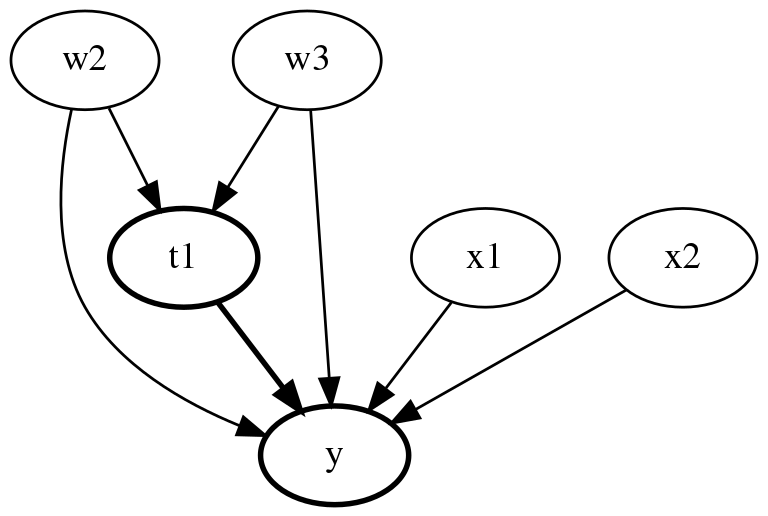

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


/home/amshar/python-environments/vpy38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}}


2022-03-02 10:15:47.235896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 10:15:47.236109: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}}


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [72.97951414763648, 73.24755545252248, 71.23537924080709, 73.72293530933325, 72.88712609901053]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-2.3540649681025876, -0.2640889121386259, -0.9572671543194481, -1.7952751298623002, -4.96775144840632]
p_value [0.11480076735957256, 0.35553975061406085, 0.3373647133673001, 0.03753928928753436, 0.019812390029227966]
true value -0.14660725043225453


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[102.54692894],
       [  1.42975104],
       [  1.6466068 ],
       [ -1.12283709],
       [  0.58743008],
       [  0.30323189]]), 'confounder=>outcome': array([[ 1.00104345e+02],
       [-1.27776060e-01],
       [ 2.77129966e-01],
       [-8.38138093e-02],
       [ 1.25350276e-01],
       [-9.27

Co-variance matrix is underdetermined. Inference will be invalid!


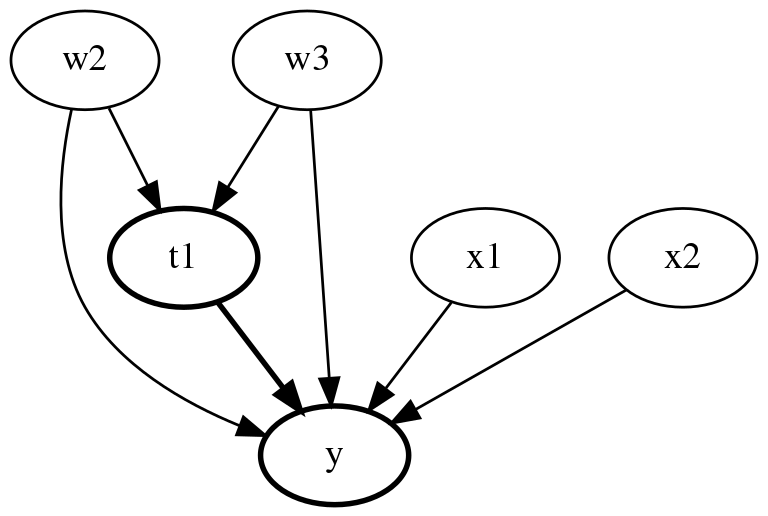

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [66.1674915230785, 66.85538646440206, 64.75464528659258, 65.34297484578234, 66.52606584393132]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.4563759201422706, 0.7733703219050371, -0.2564628599636379, -0.646212685642558, 2.754271255580786]
p_value [0.31427745654073125, 0.46722864927481406, 0.39007704210944283, 0.16180057071674703, 0.17764835165323134]
true value 0.5246949704727033


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.33845439],
       [  2.5303343 ],
       [  0.14516038],
       [ -0.37452961],
       [  1.85644198],
       [ -1.29886708]]), 'confounder=>outcome': array([[99.90278553],
       [ 1.68481513],
       [-0.75801886],
       [-0.26907698],
       [-0.22288387],
       [-1.93897461]]), 'effect_modifi

Co-variance matrix is underdetermined. Inference will be invalid!


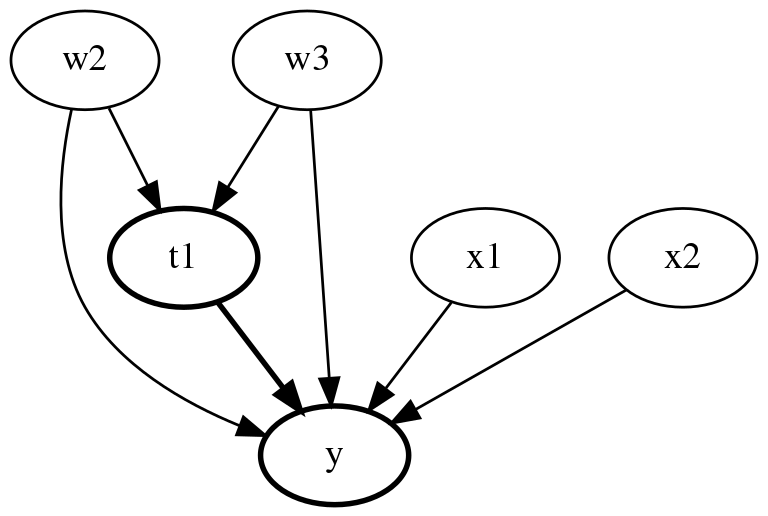

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.6899455073204, 66.99923754322302, 64.73571648586883, 63.72434680086488, 65.75144775072535]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.61063248703624, -0.08713743781362841, 3.5363282101401046, 5.008768513489399e-16, 1.6387895837922593]
p_value [0.247283832899983, 0.4269643674908109, 0.2110131305561465, 0.0, 0.2793265956751411]
true value 0.6194652694024999


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.10480343],
       [ -1.38621743],
       [ -0.39974671],
       [  0.5638876 ],
       [ -1.42539861],
       [  1.11875685]]), 'confounder=>outcome': array([[99.79685983],
       [-0.2306537 ],
       [-0.69585228],
       [-0.2580751 ],
       [ 0.9274527 ],
       [-1.20323366]]), 'effect_modifier=>outcome': arra

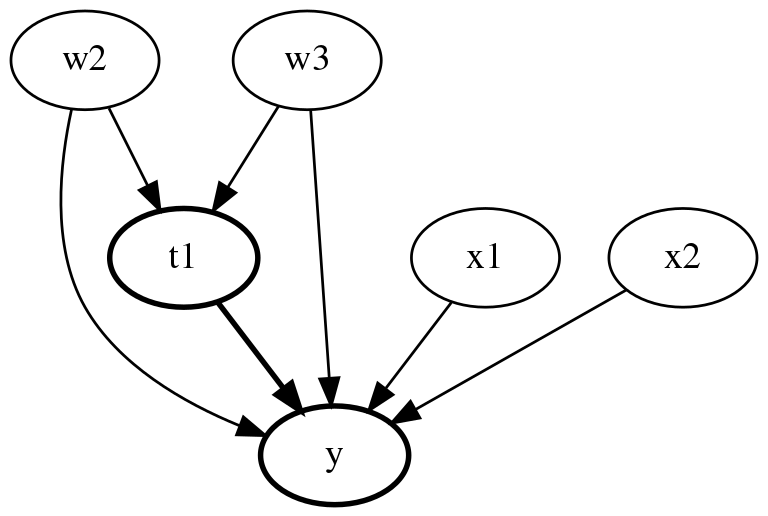

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.07669356260507, 73.9353302150129, 71.80412660266543, 62.02612424583945, 73.384937851967]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [1.2205136125107396, -1.3516282303140792, 1.5208755550816053, -0.31530968614046817, -0.5706436231715044]
p_value [0.36327890950249997, 0.11842462378449836, 0.38150951877407957, 0.1903369241267585, 0.2631925300872199]
true value -0.3063888791724129


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.94656757],
       [ 1.40073576],
       [-0.7662486 ],
       [ 0.1357568 ],
       [ 0.52720053],
       [ 1.74656011]]), 'confounder=>outcome': array([[ 9.85770882e+01],
       [ 1.06964355e+00],
       [ 1.29523793e+00],
       [ 6.82388601e-01],
       [-1.32161869e+00],
       [ 9.55608311e-

Co-variance matrix is underdetermined. Inference will be invalid!


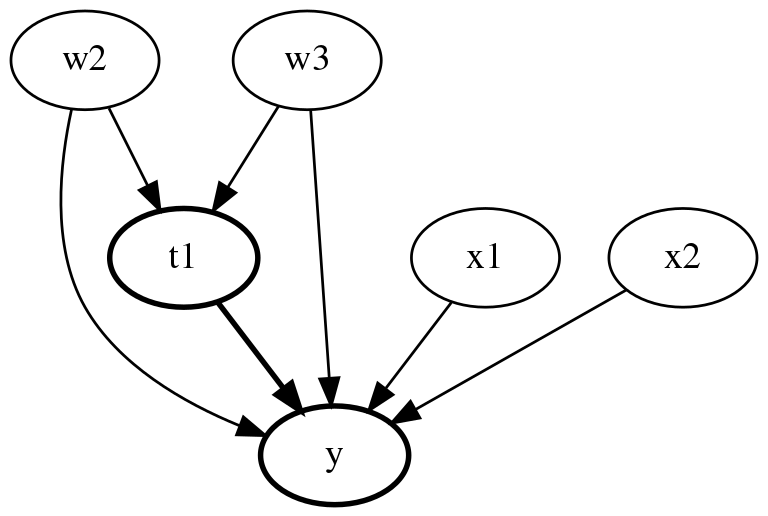

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [72.48488528554806, 69.02286589052952, 72.12862145148357, 59.638442766059484, 72.53153660366527]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.6301225395134662, 2.0942908665698297, 1.3434147750484915, 0.7478646569957538, -0.8865332755117097]
p_value [0.2541657812059216, 0.3539454880131399, 0.3837855479540747, 0.4130918509815611, 0.27698991469461975]
true value 0.11661639569789224


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01144627e+02],
       [ 7.89099802e-02],
       [-1.56628756e-01],
       [-1.43590205e+00],
       [-1.76745751e-01],
       [ 4.05422760e-03]]), 'confounder=>outcome': array([[ 1.00690713e+02],
       [ 1.02635743e+00],
       [ 1.15553495e+00],
       [-1.02920228e-02],
       [ 1.00844460e+00],
 

Co-variance matrix is underdetermined. Inference will be invalid!


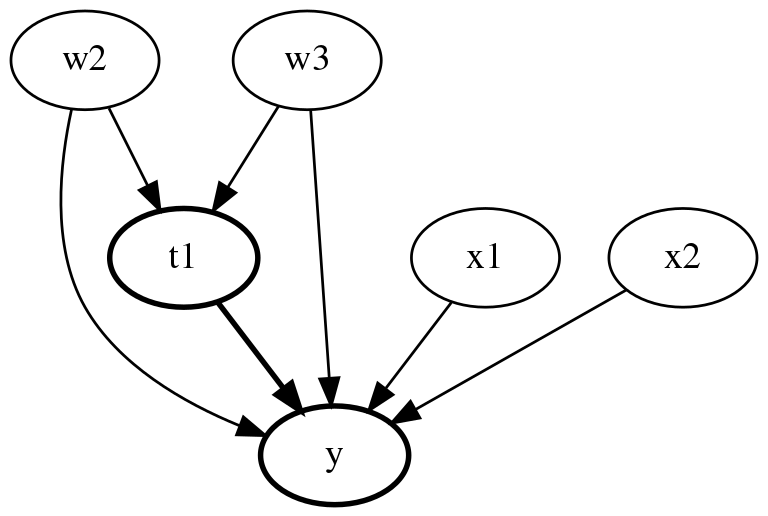

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [66.76533547523641, 70.24151515105433, 67.10397300410094, 61.418882726917246, 66.65639681267625]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [5.435540436287232, 4.822802270754273, 3.383302204250856, 1.417629878033198, 1.7518764814292944]
p_value [0.027397544511666407, 0.06047461939966106, 0.0645542094079918, 0.3043959950631514, 0.3117599672694688]
true value -1.074883063474456


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.89494516],
       [-0.95027152],
       [ 1.29461536],
       [-1.60138242],
       [-1.60849118],
       [ 0.25109645]]), 'confounder=>outcome': array([[100.3133786 ],
       [ -0.34979481],
       [ -2.3592227 ],
       [  0.98594095],
       [ -3.10987867],
       [ -1.28177694]]), 'effect_modifier=>ou

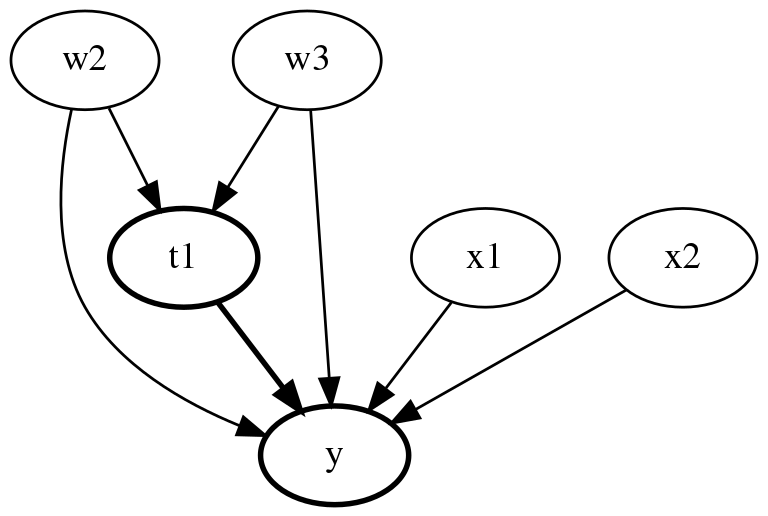

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [64.56875963032962, 66.5278665000672, 64.37140799810632, 57.386949904344846, 64.50821629601776]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [2.6693993682359247, 2.460533587768463, 1.5441002763899798, -0.18008118877454748, 1.2138447068566374]
p_value [0.13612046552960544, 0.3105324427667033, 0.4081297302088512, 0.3261337597343954, 0.35904851061581267]
true value -0.5887659083644596


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 9.92202359e+01],
       [ 2.42122944e-01],
       [ 1.40043766e-01],
       [-2.54636610e-06],
       [ 9.08538652e-01],
       [-6.95985673e-01]]), 'confounder=>outcome': array([[ 1.01095979e+02],
       [-2.15715180e+00],
       [ 1.03340784e-02],
       [ 3.21735573e-01],
       [ 1.68376435e-01],
 

Co-variance matrix is underdetermined. Inference will be invalid!


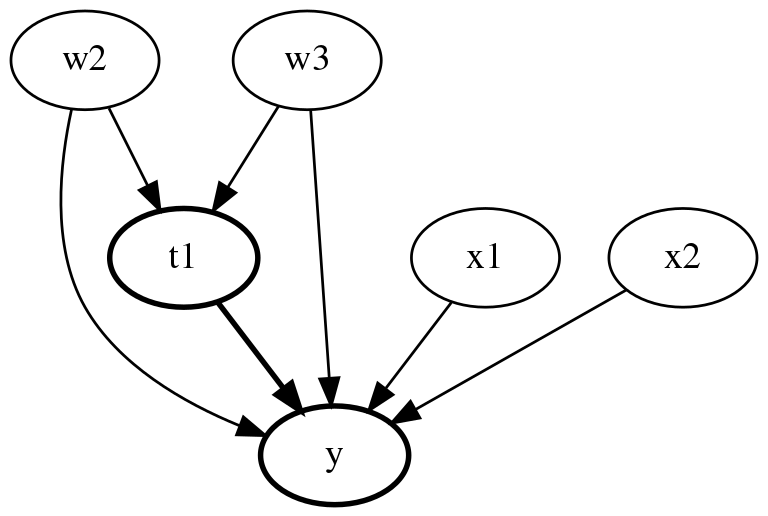

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params

 None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [68.82448105050081, 85.55285275450014, 70.17004078546032, 61.55548428472502, 69.96962959729214]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.5756016515349778, -0.3138209399144786, 0.9975128006994695, 0.14901089466494, 0.2805912886502318]
p_value [0.39709209742488927, 0.4224864349212889, 0.43618032569238696, 0.3892640427740869, 0.46600162394711764]
true value -0.33133224530772326


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.73715178],
       [  1.62023161],
       [  2.40940167],
       [ -0.5022416 ],
       [ -1.15602081],
       [ -0.53719231]]), 'confounder=>outcome': array([[ 9.93065142e+01],
       [ 2.05531102e+00],
       [ 1.24248535e+00],
       [-6.11784588e-01],
       [-6.96124216e-02],
       [-1.0126223

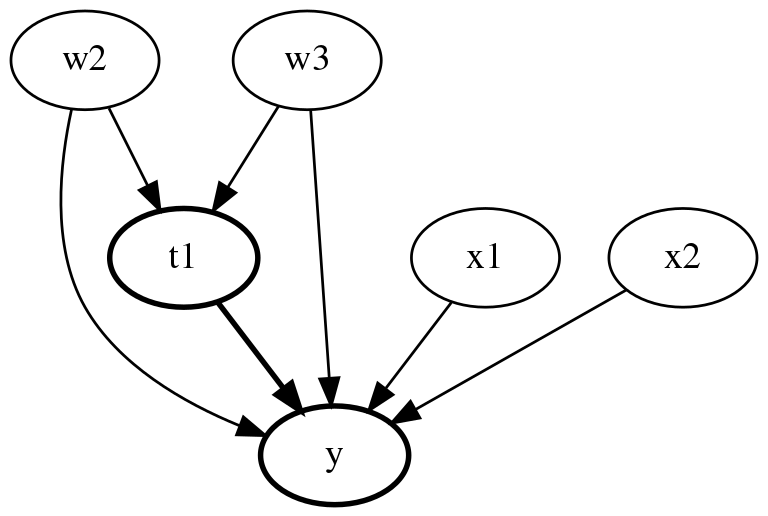

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [50.62394343789601, 55.76126356484053, 51.99780225335623, 50.80518540989741, 50.830424752204536]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-0.22117568903051463, 0.8968465695485228, 1.6347652953559844, 0.6501756969312676, -0.26392986275909813]
p_value [0.40607477657298374, 0.41915404045352356, 0.39073096149981357, 0.45402894777489233, 0.2727206183910511]
true value 0.41693833747549086


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01171296e+02],
       [-6.68824125e-01],
       [ 7.25283165e-02],
       [ 1.45203583e+00],
       [ 2.80535318e-01],
       [-2.27790996e-01]]), 'confounder=>outcome': array([[99.00321216],
       [-0.78607197],
       [ 0.44402023],
       [ 0.13153755],
       [-1.31926912],
       [ 0.33705

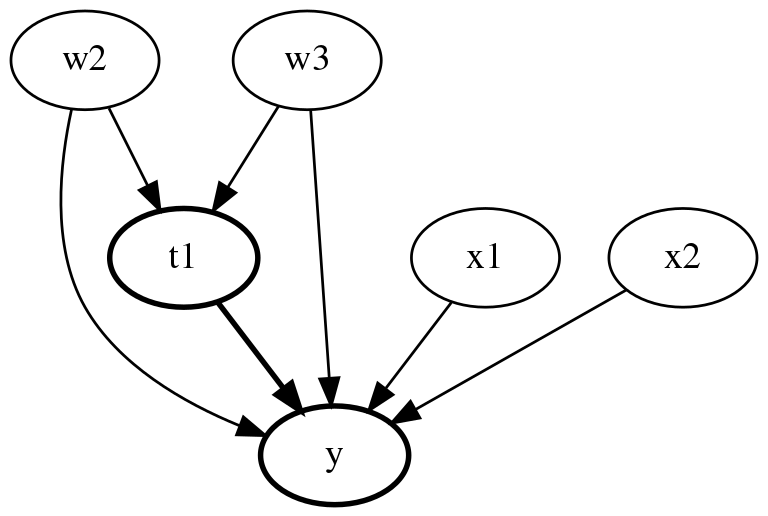

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [57.13248694540903, 53.45314139527743, 56.952035388371876, 48.77833614907823, 57.31132788602164]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})


Co-variance matrix is underdetermined. Inference will be invalid!
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


printing refute's type
<class 'list'>


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [-1.186665736268264, -2.8398237014112424, -1.2568692009713622, 0.3180042890969842, 0.9812533231418064]
p_value [0.32037571625435834, 0.07600058362237883, 0.26771864101367415, 0.24766695664092775, 0.4395782038468923]
true value -1.0663222094900675


Completed all experiments. Saving the data...
Data has been saved in  results/Test_1_2022-03-02_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [8]:
# Define the properties of the experiment
# The name of the experiment
# The experiment ID
# The number of experiments to be run with the SAME parameters
# The size of the samples to be run
# The list of DGPs to be run
# The list of estimators
observed_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='1',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = False 
)

# Run the experiment
res = pd.read_csv(observed_confounding_error.experiment())

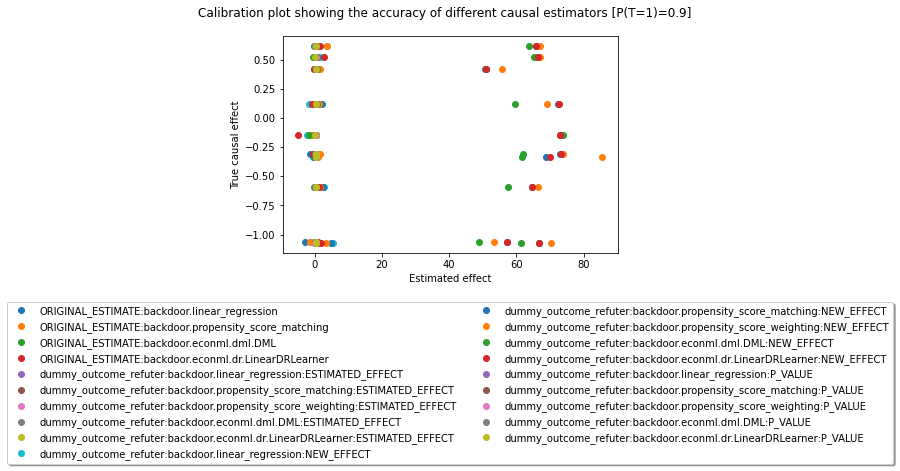

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 68.34335995146225
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 66.21936940767047
ORIGINAL_ESTIMATE:backdoor.linear_regression 66.0150121148753
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 60.62362470260349
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 2.017526304774168
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 1.7307186639629866
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 1.689101393651449
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 1.531357940211754
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 0.9078314532326781
dummy_outcome_refuter:backdoor.linear_regression:ESTIMATED_EFFECT 0.7124905062943194
dummy_outcome_refuter:backdoor.propensity_score_matching:ESTIMATED_EFFECT 0.7124905062943194
dummy_outcome_refuter:backdoor.propensity_score_weighting:ESTIMATED_EFFECT 0.7124905062943194
dummy_outcome_

In [9]:
#PLOT
#This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator. 
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. LinearRegression 
3. LinearDRLearner 
4. Propensity Score Matching 

In [10]:
estimator_list = ["backdoor.linear_regression",
                  #"backdoor.propensity_score_stratification",
                  "backdoor.propensity_score_matching",
                  "backdoor.econml.dml.DML",
                  "backdoor.econml.dr.LinearDRLearner",
                  #"backdoor.econml.metalearners.TLearner",
                  #"backdoor.econml.metalearners.XLearner",
                  #"backdoor.causalml.inference.meta.LRSRegressor",
                  #"backdoor.causalml.inference.meta.XGBTRegressor",
                  #"backdoor.causalml.inference.meta.MLPTRegressor",
                  #"backdoor.causalml.inference.meta.BaseXRegressor"
                ]

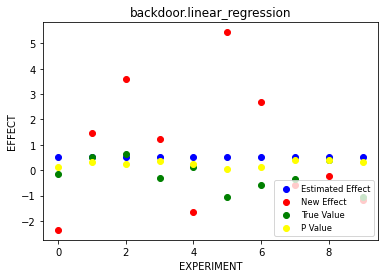

8.424831239762597


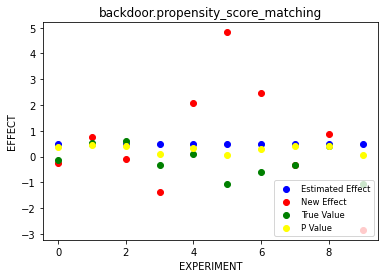

6.1913443949540685


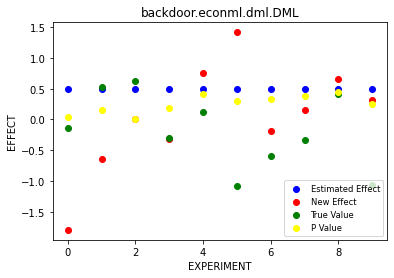

0.3458067253022701


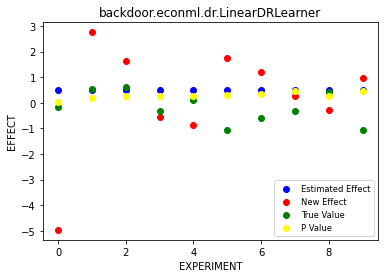

1.931768429602383


<Figure size 432x288 with 0 Axes>

In [11]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value 
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

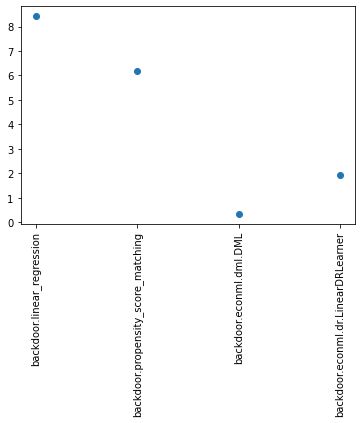

backdoor.linear_regression: 8.424831239762597
backdoor.propensity_score_matching: 6.1913443949540685
backdoor.econml.dml.DML: 0.3458067253022701
backdoor.econml.dr.LinearDRLearner: 1.931768429602383


In [12]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [13]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}


{'backdoor.linear_regression': 8.424831239762597,
 'backdoor.propensity_score_matching': 6.1913443949540685,
 'backdoor.econml.dr.LinearDRLearner': 1.931768429602383,
 'backdoor.econml.dml.DML': 0.3458067253022701}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. Propensity Score Matching 
2. Linear DR Learner 
3. DML CATE Estimator 
4. Linear Regression

Clearly, the observed unmodelled confounding error is not able to match the ranking based on the Original Estimate. It is not even able to tell that the clear winner amongst the methods according to the true value is DML CATE Estimator 

## Unobserved confounding error

For each estimator, we now simulate unobserved confounders and check its effect using dummy outcome refuter to check the unobserved confounding error for each estimator. That is, we run the refutation test for each estimator not only on the observed confounder, but also on an unobserved confounder that we simulate using the AddUnobservedCommonCause class and analyse whether there is a strong confounder that is unobserved (missing) and needs to be accounted for. 



Running Experiment: Test_2


Running Experiment Number: 0


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.86310478],
       [  0.63617126],
       [  1.54125546],
       [  0.36444857],
       [  1.52982775],
       [ -0.21138205]]), 'confounder=>outcome': array([[101.26124495],
       [ -1.26852531],
       [  0.35341168],
       [ -0.84248364],
       [  0.95100902],
       [  0.36682545]]), 'effect_modifier=>outcome': array([[ 0.39936262],
       [-0.01333126]]), 'treatment=>outcome': array([[-1.06632221]])}
        bias: {'confounder=>treatment': array([0.85055815]), 'confounder=>outcome': array([0.60566836])}
        seed: None
        treatment_is_binary: True
        percentile: 0.9
        
print

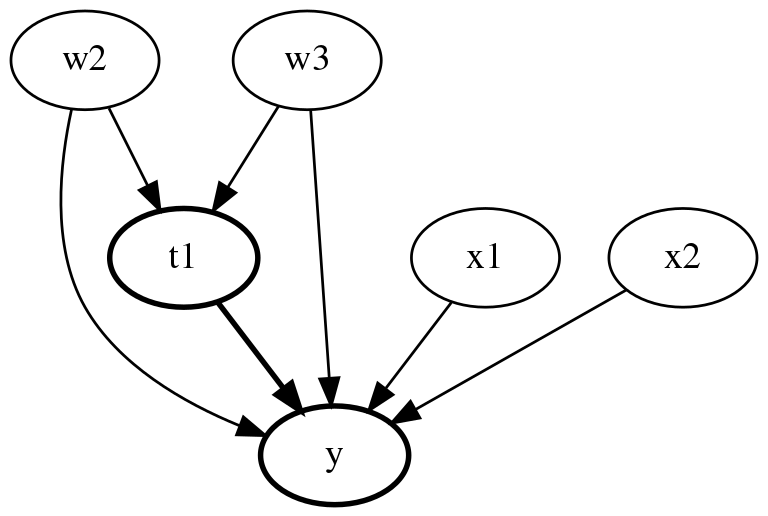

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params 

None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [69.45289924492648, 59.65614427468216, 69.87261498209274, 69.91778292377879, 69.3696459080966]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       847.010869
1      1115.554028
2      -652.860827
3      3573.656825
4      2019.004174
          ...     
995   -3067.876703
996     -26.316378
997    1401.748338
998    3642.509611
999    1522.693667
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78464bf4f0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       848.295030
1      1116.007553
2      -653.767520
3      3573.819346
4      2020.656434
          ...     
995   -3068.733216
996     -27.569824
997    1402.687602
998    3640.751149
999    1524.282645
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844ea6580>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       848.827321
1      1114.692594
2      -652.993869
3      3574.473209
4      2021.498866
          ...     
995   -3069.516208
996     -27.447191
997    1400.393230
998    3641.705530
999    1521.367679
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844ea64c0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       850.184702
1      1116.600277
2      -654.106536
3      3574.203182
4      2019.585653
          ...     
995   -3069.460486
996     -27.093251
997    1399.878590
998    3641.178713
999    1523.226421
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78f33b7be0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       847.692517
1      1115.669297
2      -653.541725
3      3574.746691
4      2023.297734
          ...     
995   -3067.958667
996     -29.144169
997    1401.658150
998    3641.943067
999    1523.196842
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [5.177582619500304, 13.318551260534615, 13.715415099033248, 8.57777304991858, 0.03375900998331538]
p_value [0.22756070269496514, 0.1180749158767575, 0.055305331010443805, 0.1536542149055612, 0.47035651109280086]
true value 2.2792355759571015


Running Experiment Number: 1


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[ 1.01722302e+02],
       [ 1.10808557e+00],
       [ 1.58153420e+00],
       [-7.64291217e-01],
       [-4.57052462e-02],
       [-6.93466210e-01]]), 'confounder=>outcome': array([[ 1.00379518e+02],
       [ 2.03609745e+00],
       [ 3.24682914e-01],
       [ 2.66915082e-01],
       [-7.09978040e-02],
   

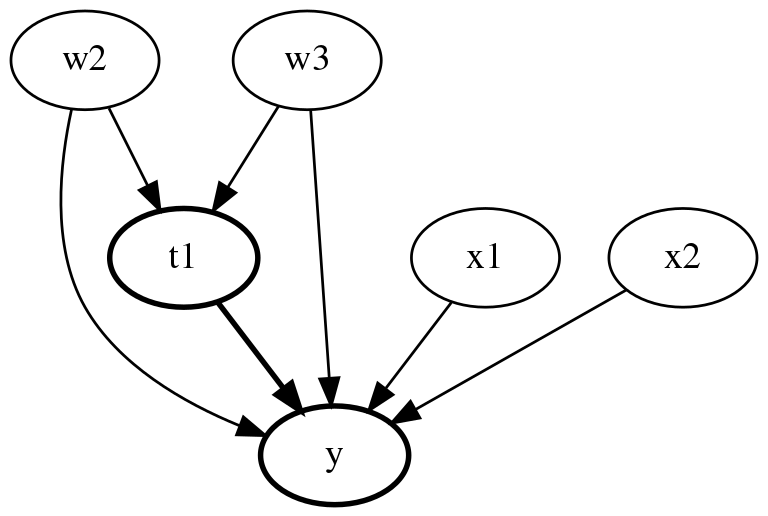

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)


estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [73.6594227422863, 69.8572112951081, 73.78443606335033, 69.97246805751057, 73.50498796506194]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       847.692517
1      1115.669297
2      -653.541725
3      3574.746691
4      

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       769.945277
1      -603.650051
2      1331.862689
3      -154.406381
4      -357.739470
          ...     
995    -677.825909
996   -1202.783341
997   -3535.058913
998      20.317808
999   -1027.464141
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7845061e50>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       767.264192
1      -600.282738
2      1332.889102
3      -158.207836
4      -357.260839
          ...     
995    -677.597834
996   -1202.817426
997   -3535.311615
998      21.638115
999   -1028.848049
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844e9b2b0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       767.482643
1      -602.036931
2      1332.426799
3      -156.939681
4      -355.847725
          ...     
995    -679.480000
996   -1202.379028
997   -3535.389295
998      21.027223
999   -1028.989188
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844f24580>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       768.210030
1      -601.918279
2      1331.690219
3      -155.887049
4      -358.387511
          ...     
995    -676.923132
996   -1202.257987
997   -3536.172219
998      20.177658
999   -1029.067347
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7845077e50>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       769.191459
1      -601.500693
2      1333.719632
3      -156.181997
4      -356.733817
          ...     
995    -677.748759
996   -1203.745501
997   -3535.518020
998      20.794050
999   -1030.109689
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [11.80666353445712, 6.1464542384494445, 10.502480469888132, 5.47990398090776, 5.517053919788362]
p_value [0.01810931092826943, 0.2866388760014795, 0.006058966343111975, 0.35137931521298665, 0.2689575728408772]
true value 0.6816421133821597


Running Experiment Number: 2


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.55275304],
       [-0.2372805 ],
       [ 1.66520744],
       [-0.5967259 ],
       [ 0.11037351],
       [-2.23210792]]), 'confounder=>outcome': array([[ 1.00229340e+02],
       [-2.11482983e-01],
       [ 1.73210819e+00],
       [-2.96950830e-01],
       [ 6.82337252e-01],
       [ 4.96675472e-02]]), '

Co-variance matrix is underdetermined. Inference will be invalid!


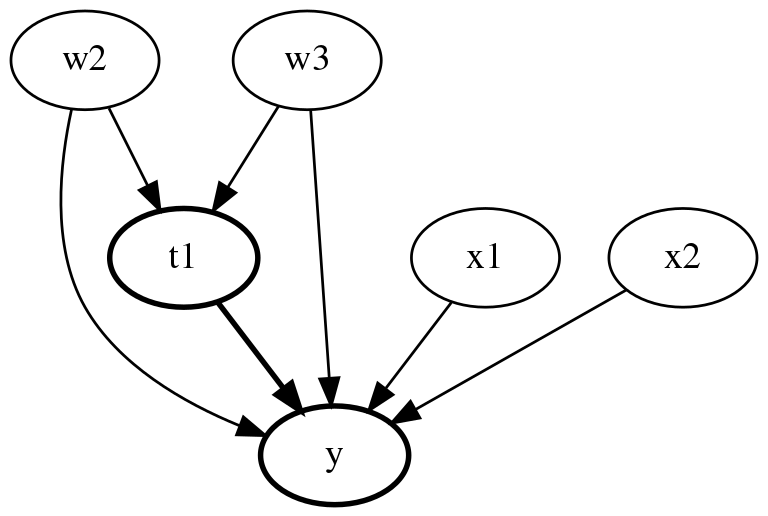

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [60.63597333836037, 58.89582464203396, 59.53649046027437, 51.101651905371604, 61.1117330071961]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       769.191459
1      -601.500693
2      1333.719632
3      -156.181997
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1679.331637
1     -6391.809754
2      1445.113244
3     -2615.576921
4     -1987.804197
          ...     
995    -727.117891
996    -346.007549
997   -1191.271323
998    3316.810016
999    1816.320122
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844e4d790>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1678.992807
1     -6391.911162
2      1445.242970
3     -2614.926345
4     -1990.678041
          ...     
995    -730.732334
996    -347.386011
997   -1191.824639
998    3318.882513
999    1815.547920
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78452a4820>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1678.777479
1     -6392.282807
2      1444.343508
3     -2615.566299
4     -1989.923663
          ...     
995    -730.125614
996    -347.838445
997   -1191.236657
998    3317.076209
999    1816.481509
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844e06b20>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1678.764800
1     -6391.133382
2      1445.141744
3     -2615.223945
4     -1990.662511
          ...     
995    -729.607781
996    -348.815043
997   -1190.563498
998    3317.601622
999    1816.136936
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78464034f0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1677.959389
1     -6392.336283
2      1445.117022
3     -2612.428756
4     -1989.782866
          ...     
995    -731.187433
996    -348.416257
997   -1189.324909
998    3320.094655
999    1816.158870
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.2119490931462757, -10.229580895162286, -1.7022953091165385, 1.6417730696792538, 5.007075678039337]
p_value [0.32800297478865553, 0.07587168172086867, 0.3735368139858659, 0.4634864760942206, 0.16150612986792123]
true value 1.5405666535717248


Running Experiment Number: 3


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.80434156],
       [ -1.23810712],
       [ -0.30196104],
       [ -1.90823588],
       [ -0.51855561],
       [ -1.02854147]]), 'confounder=>outcome': array([[101.56902979],
       [ -1.62496032],
       [ -1.00668056],
       [ -2.26182315],
       [  1.46967279],
       [ -0.51909446]]), 'effect_m

Co-variance matrix is underdetermined. Inference will be invalid!


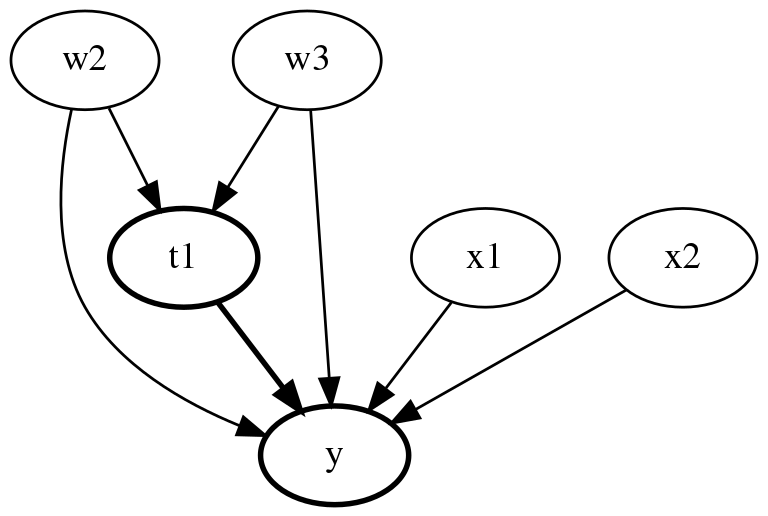

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [72.96632217627543, 77.01832764129364, 72.63206501948798, 55.40640517560925, 72.99953631091002]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -1677.959389
1     -6392.336283
2      1445.117022
3     -2612.428756
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1445.214685
1      2551.433363
2     -1072.226098
3     -1283.604030
4      1010.200999
          ...     
995    -536.612811
996   -1041.143638
997   -1479.608271
998    1503.724186
999   -1777.499146
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7845230af0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1443.786200
1      2550.034835
2     -1072.052043
3     -1284.082568
4      1010.424132
          ...     
995    -537.015180
996   -1040.962452
997   -1477.789830
998    1503.737576
999   -1774.824401
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844ad5f40>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1443.018424
1      2550.815602
2     -1072.156715
3     -1282.652793
4      1010.810872
          ...     
995    -536.476092
996   -1042.030486
997   -1480.245334
998    1501.723954
999   -1774.015913
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78464224f0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1444.643537
1      2549.808142
2     -1070.413357
3     -1283.478251
4      1009.949483
          ...     
995    -538.214326
996   -1040.556420
997   -1479.110709
998    1501.436098
999   -1776.159935
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78464be6d0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1445.316569
1      2548.115777
2     -1071.595363
3     -1284.423488
4      1010.254665
          ...     
995    -537.499997
996   -1041.647662
997   -1478.906274
998    1503.641338
999   -1776.633488
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [5.206917530569817, 16.59946581683773, 5.477602504114498, 4.795836083890727, 3.161647962223264]
p_value [0.25771930091294515, 0.09222203477110169, 0.24708434627546627, 0.2337826345609687, 0.24420277711069083]
true value 0.1801366675658666


Running Experiment Number: 4


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.02441455],
       [ -0.14867504],
       [  0.18239508],
       [ -0.83541789],
       [ -0.49153505],
       [  0.88398599]]), 'confounder=>outcome': array([[100.22822138],
       [ -1.37686658],
       [ -1.2156416 ],
       [  0.62802725],
       [  1.90209419],
       [  0.74871392]]), 'effect_modifi

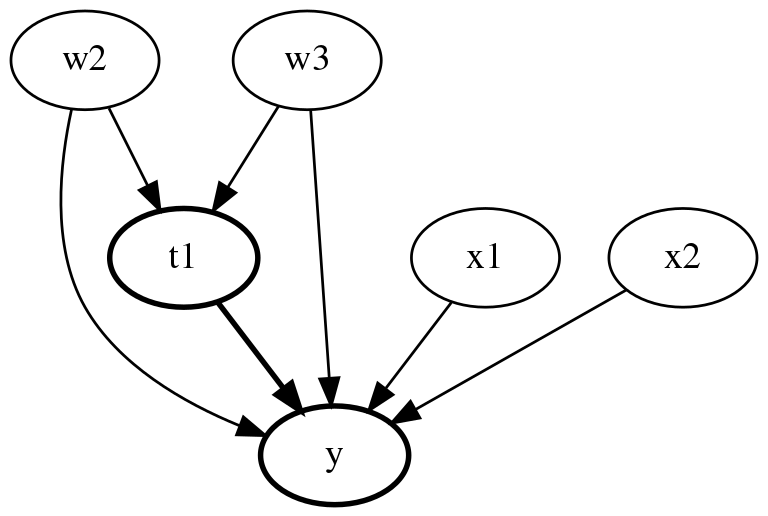

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [62.07915533945592, 62.34625395469203, 58.93426120057349, 59.73763602959992, 62.37682578198588]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0      1445.316569
1      2548.115777
2     -1071.595363
3     -1284.423488
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2950.639787
1     -2793.857547
2       -43.875373
3      -593.634895
4      2239.467624
          ...     
995    1110.477469
996     245.864174
997     -83.688148
998   -2397.476431
999   -1768.443962
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78451f0d90>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2950.179693
1     -2792.392675
2       -42.760611
3      -595.483474
4      2241.279212
          ...     
995    1111.989797
996     242.734680
997     -82.809465
998   -2396.627825
999   -1768.860661
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844f7ad60>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2951.178228
1     -2793.714123
2       -44.577904
3      -591.210741
4      2239.832888
          ...     
995    1113.970089
996     243.856464
997     -84.621971
998   -2396.928930
999   -1768.742583
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78451f0610>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2948.648888
1     -2793.933547
2       -45.568897
3      -593.561847
4      2240.044699
          ...     
995    1111.337025
996     242.710490
997     -83.058949
998   -2397.343514
999   -1770.169083
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78451f0d90>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2948.017812
1     -2793.828133
2       -45.294800
3      -592.219819
4      2239.151804
          ...     
995    1111.144327
996     243.964788
997     -84.246345
998   -2397.406576
999   -1769.093719
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [21.00404977767471, 19.107276634696827, 11.970890851746507, 18.521416652474066, 18.382113672067938]
p_value [0.007699518014915488, 0.02498480155215618, 0.003982846065882695, 0.07287469650070198, 0.0013557397793021297]
true value -0.47209679203476057


Running Experiment Number: 5


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[98.52716637],
       [ 0.27589015],
       [-0.80473151],
       [-0.50047851],
       [-0.32305169],
       [ 2.42572915]]), 'confounder=>outcome': array([[101.38868177],
       [  1.78403018],
       [  0.7401208 ],
       [ -1.65142206],
       [ -0.94168852],
       [ -2.09190395]]), 'effect_m

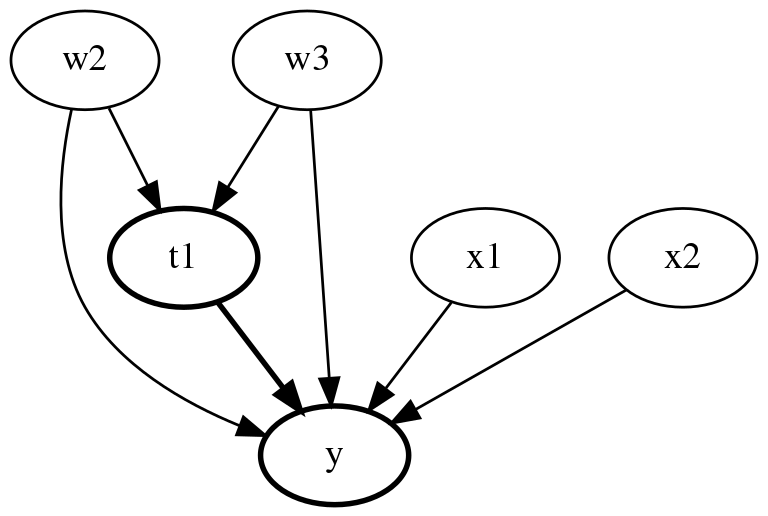

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [65.09963645911861, 67.10884146355691, 65.52443477990583, 61.098204493894634, 64.63635698831911]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2948.017812
1     -2793.828133
2       -45.294800
3      -592.219819
4   

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       232.261027
1      -659.209603
2     -2012.341404
3      -698.687863
4      1003.860425
          ...     
995   -1631.287870
996    -117.990716
997     206.389848
998    1922.899646
999   -2192.661154
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844b44d90>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       232.610671
1      -658.514125
2     -2012.381657
3      -697.796887
4      1002.571868
          ...     
995   -1631.459185
996    -117.161218
997     207.545578
998    1923.464145
999   -2191.355552
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844b447c0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       231.811825
1      -656.553703
2     -2012.126558
3      -697.065994
4      1002.115759
          ...     
995   -1630.821804
996    -116.543747
997     205.359759
998    1923.383932
999   -2190.966881
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844b44ca0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       232.163312
1      -657.892831
2     -2013.554331
3      -697.308391
4      1004.565032
          ...     
995   -1630.421485
996    -118.435595
997     206.358223
998    1920.642511
999   -2192.728283
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7846698130>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       231.522152
1      -659.670876
2     -2010.473441
3      -697.972934
4      1002.947202
          ...     
995   -1631.990360
996    -116.691977
997     205.203280
998    1922.020861
999   -2192.925812
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [8.951535663560685, 11.63671314309768, -0.20996917782305458, 2.052661969333459, -2.025354195219851]
p_value [0.05308748100532683, 0.1816867993976392, 0.39834093389124237, 0.42812695707518544, 0.38549791841106507]
true value 0.37168705353141435


Running Experiment Number: 6


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[99.78498965],
       [-0.80652592],
       [-0.27500707],
       [-0.39205656],
       [-1.24455266],
       [ 1.07678165]]), 'confounder=>outcome': array([[100.64544825],
       [ -1.00078907],
       [  0.38709262],
       [ -0.59585189],
       [ -0.9791369 ],
       [  1.65303827]]), 'effect_modifie

Co-variance matrix is underdetermined. Inference will be invalid!


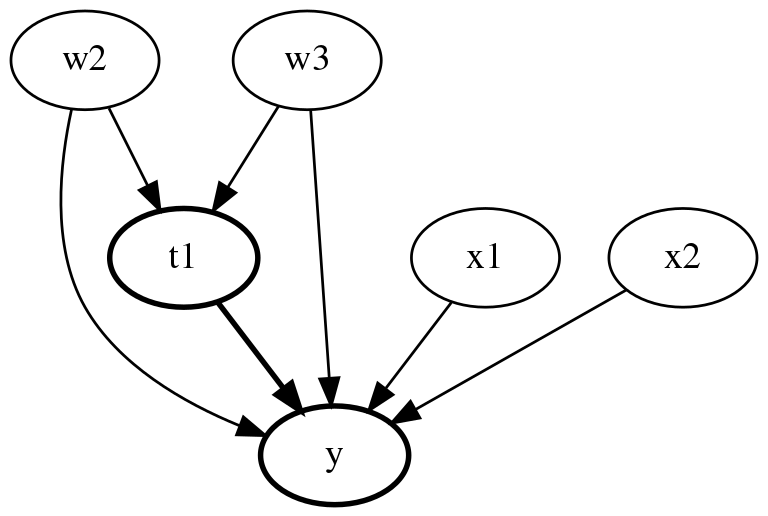

divide by zero encountered in double_scalars


identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [59.63656681144565, 70.80923058283928, 59.54545564189914, 57.89543165936835, 59.40085360315823]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       231.522152
1      -659.670876
2     -2010.473441
3      -697.972934
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2028.227391
1       -74.808492
2      1946.513093
3      -360.653073
4        52.300700
          ...     
995     918.108589
996    3706.455962
997     653.885257
998    -639.341511
999    -253.761561
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7846601700>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2025.227991
1       -73.415747
2      1945.860976
3      -359.389878
4        51.464903
          ...     
995     918.976522
996    3706.234552
997     654.279590
998    -640.828986
999    -254.668811
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78450c7190>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2025.125558
1       -76.752282
2      1945.745301
3      -358.811315
4        51.959758
          ...     
995     917.878679
996    3705.615521
997     653.618231
998    -640.155929
999    -252.100218
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7846661cd0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2027.269803
1       -75.473798
2      1944.729787
3      -358.761906
4        52.964028
          ...     
995     918.452860
996    3707.880625
997     651.950691
998    -640.559176
999    -253.266852
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844da6c70>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2025.673563
1       -74.407769
2      1945.793450
3      -359.196304
4        53.267029
          ...     
995     918.433769
996    3704.461470
997     655.029128
998    -639.899984
999    -253.873178
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [6.862897571514847, 17.163569063224106, 9.952760213657475, 7.83816658115268, 4.009809258793333]
p_value [0.1339306336423698, 0.18863397292620782, 0.018427053531901577, 0.2501901040931147, 0.35311164057994693]
true value -0.5120803369521811


Running Experiment Number: 7


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[103.09086966],
       [  1.09720495],
       [  0.38490769],
       [  0.99172238],
       [ -1.05010159],
       [  1.59125818]]), 'confounder=>outcome': array([[99.64472492],
       [ 1.33003461],
       [ 0.84881146],
       [ 1.68093539],
       [-0.85408497],
       [-0.74490785]]), 'effect_modifier=>o

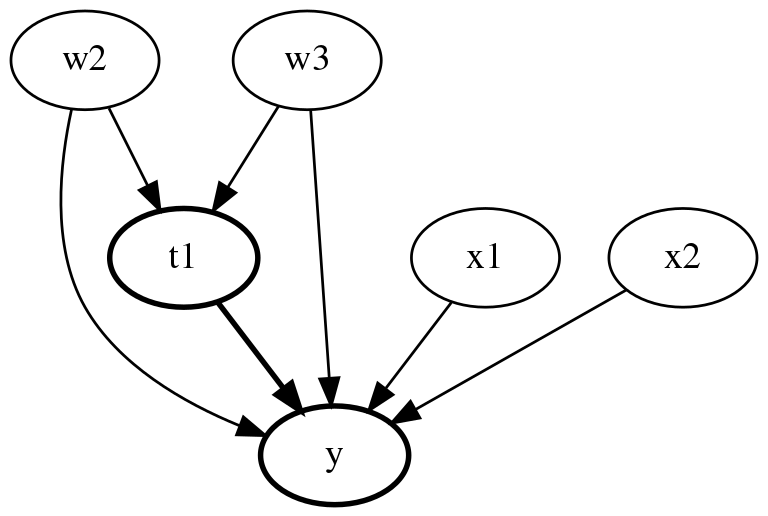

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}


Co-variance matrix is underdetermined. Inference will be invalid!


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [67.11989437062482, 69.94894707155635, 66.1508446867158, 58.651596044447714, 67.26664240787976]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0     -2025.673563
1       -74.407769
2      1945.793450
3      -359.196304
4        53.267029
          ...     
995     918.433769
996    3704.461470
997     655.029128
998    -639.899984
999    -253.873178
Length: 1000, dtype: float64})
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844d989d0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -67.182761
1       268.162210
2      -270.176563
3      -751.297318
4      -320.989392
          ...     
995     735.229412
996    1772.579039
997   -1117.972707
998     195.994724
999     162.815939
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844e46df0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -67.892845
1       268.672472
2      -271.957159
3      -752.596420
4      -321.638210
          ...     
995     735.409247
996    1772.913890
997   -1120.068624
998     198.038279
999     165.647304
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78463c6f10>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -67.407444
1       267.984336
2      -272.970027
3      -752.195390
4      -321.792707
          ...     
995     737.104325
996    1772.870800
997   -1118.950189
998     195.836196
999     164.024674
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f78451d2640>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -68.186077
1       269.797458
2      -271.958813
3      -750.117194
4      -321.869064
          ...     
995     737.006780
996    1774.172336
997   -1118.929424
998     195.156805
999     164.596438
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f784657cb20>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -68.517452
1       270.625868
2      -271.705630
3      -753.197874
4      -321.805250
          ...     
995     735.507720
996    1772.973877
997   -1118.458393
998     196.142527
999     165.328683
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [8.155427096489902, 11.810335290129952, 9.30512886314582, 19.19213769227935, 8.596045407696176]
p_value [0.16972896819054706, 0.10745983182955332, 0.0036975877657847212, 0.12828986570371204, 0.12558394902398662]
true value 1.272962485151482


Running Experiment Number: 8


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[101.87290033],
       [  1.1871212 ],
       [ -0.34395076],
       [  0.78820313],
       [  0.4222783 ],
       [  0.1943532 ]]), 'confounder=>outcome': array([[99.53970352],
       [-0.51382427],
       [ 0.77046477],
       [-1.52233512],
       [ 0.48575287],
       [ 1.20121431]]), 'effect_modifier=>

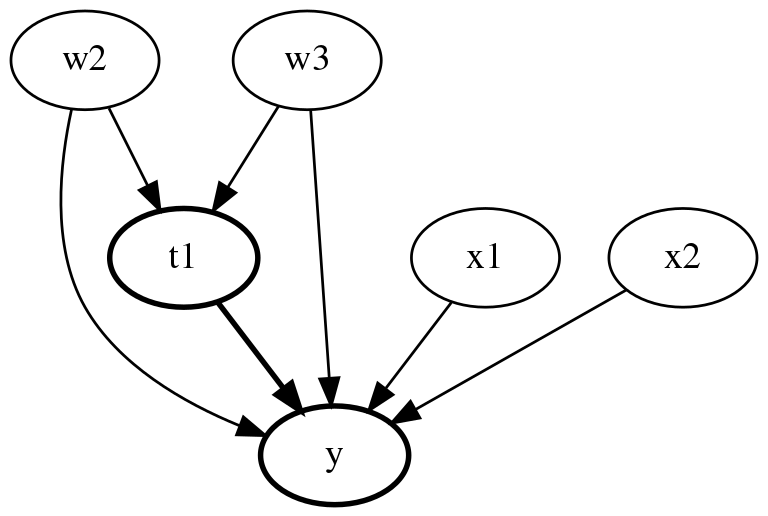

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [72.18240395332244, 66.95877851075792, 73.27576601648781, 71.24637190372287, 72.83801974133483]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       -68.517452
1       270.625868
2      -271.705630
3      -753.197874
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       474.128250
1      -523.763515
2     -1831.847923
3     -2090.287173
4     -4325.640849
          ...     
995     809.373179
996   -2494.894733
997    -282.813273
998     175.595063
999   -2222.633875
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844fc9070>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       476.358134
1      -523.836173
2     -1830.924611
3     -2090.185685
4     -4326.587495
          ...     
995     808.866623
996   -2492.599855
997    -281.553015
998     175.691935
999   -2220.785611
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844fc9eb0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       474.668329
1      -525.672309
2     -1828.822340
3     -2089.825114
4     -4326.191384
          ...     
995     808.526573
996   -2492.738722
997    -283.697566
998     174.330901
999   -2221.522011
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f784daa2190>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       474.181604
1      -525.810514
2     -1829.828574
3     -2090.905525
4     -4327.416457
          ...     
995     807.935788
996   -2491.494644
997    -283.911299
998     177.112092
999   -2222.564931
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844b590a0>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       476.062360
1      -523.875707
2     -1829.045284
3     -2090.516702
4     -4325.104966
          ...     
995     810.198855
996   -2490.440372
997    -282.703027
998     174.952825
999   -2220.253911
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [9.56418805087097, 17.71782959958133, 11.289658617556121, 14.112789927087764, 7.923498361766749]
p_value [0.09066180569377158, 0.1199859947256311, 0.04416894013720861, 0.08946411887201594, 0.24614961768402527]
true value 1.4549935695266385


Running Experiment Number: 9


Current Sample Size: 1000


The current DGP:

        Linear Data Generating Process
        -------------------------------
        
        treatment:['t1']
        outcome:['y']
        confounder: ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
        effect_modifier: ['x1', 'x2']
        weights: {'confounder=>treatment': array([[100.46901513],
       [ -0.18360882],
       [  0.23235846],
       [ -0.37167707],
       [  0.71272892],
       [ -0.98904922]]), 'confounder=>outcome': array([[1.00025121e+02],
       [6.82656712e-01],
       [5.61406596e-01],
       [6.41511118e-01],
       [6.58815996e-02],
       [1.02249640e+00]]), '

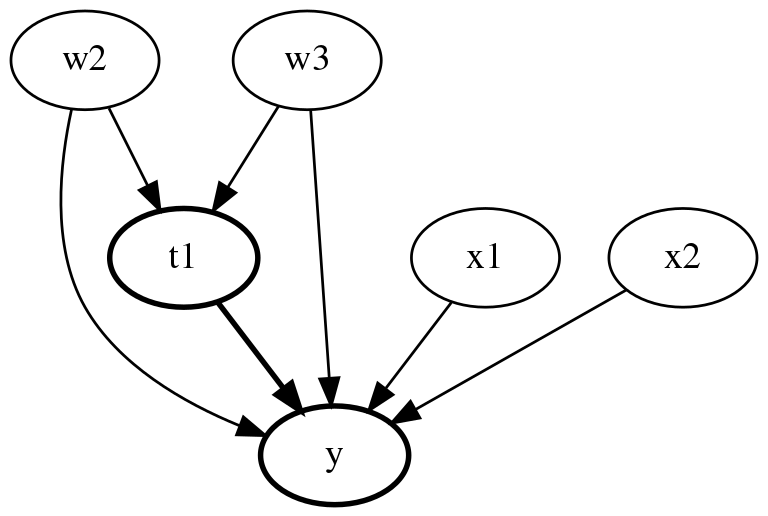

identified_estimand: Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                        
─────(Expectation(y|w3,w2))
d[t₁]                      
Estimand assumption 1, Unconfoundedness: If U→{t1} and U→y then P(y|t1,w3,w2,U) = P(y|t1,w3,w2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Running the estimators:

The current estimator: Estimator(name='backdoor.linear_regression', params=None)
estimator.params None
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_matching', params={'init_params': {}})
estimator.params {'init_params': {}}


divide by zero encountered in double_scalars


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.propensity_score_weighting', params={'init_params': {}})
estimator.params {'init_params': {}}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dml.DML', params={'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'})
estimator.params {'init_params': {'model_y': GradientBoostingRegressor(), 'model_t': GradientBoostingRegressor(), 'model_final': LassoCV(fit_intercept=False), 'featurizer': PolynomialFeatures(degree=1)}, 'fit_params': {}, '_econml_methodname': 'econml.dml.DML'}


printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
The current estimator: Estimator(name='backdoor.econml.dr.LinearDRLearner', params={'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'})
estimator.params {'init_params': {'model_propensity': LogisticRegressionCV(cv=3)}, 'fit_params': {}, '_econml_methodname': 'econml.dr.LinearDRLearner'}
printing estimate's type
<class 'dowhy.causal_estimator.CausalEstimate'>
estimate_values [59.57001117751645, 62.36679740611476, 59.36853358399933, 52.7687281690154, 59.450742991982125]


Running the refuters:

The current refuter: Refuter(name='dummy_outcome_refuter', params={'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       476.062360
1      -523.875707
2     -1829.045284
3     -2090.516702
4    

Co-variance matrix is underdetermined. Inference will be invalid!


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       699.750736
1     -1972.116879
2      3026.278949
3       356.905837
4      -126.929640
          ...     
995    -905.601593
996    -200.848838
997   -2420.509128
998   -3178.227237
999   -1205.856601
Length: 1000, dtype: float64}


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7846495670>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       700.881211
1     -1973.647072
2      3025.606868
3       356.826885
4      -128.510159
          ...     
995    -908.011548
996    -200.375592
997   -2421.695931
998   -3174.878682
999   -1206.877803
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844bb2100>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       700.958417
1     -1974.083818
2      3024.975531
3       353.863882
4      -127.392611
          ...     
995    -908.647898
996    -200.687901
997   -2419.406275
998   -3177.577613
999   -1204.413337
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7846716e20>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       702.248478
1     -1972.083758
2      3024.649476
3       355.527110
4      -128.071789
          ...     
995    -906.806415
996    -200.529223
997   -2421.762174
998   -3175.736155
999   -1206.705215
Length: 1000, dtype: float64}


printing refute's type
<class 'list'>
********%%%%%%%%%$$$$$&&^**^^^^*^*^*
add_unobserved_confounder <dowhy.causal_refuters.add_unobserved_common_cause.AddUnobservedCommonCause object at 0x7f7844b4ef70>


refuter.params {'num_simulations': 5, 'transformation_list': [('random_forest', {'n_estimators': 100, 'max_depth': 6})], 'true_causal_effect': <function <lambda> at 0x7f78f3382430>, 'unobserved_confounder_values': 0       701.017371
1     -1972.230760
2      3025.172939
3       355.642614
4      -128.395831
          ...     
995    -907.788171
996    -201.047542
997   -2420.329556
998   -3177.997074
999   -1205.376357
Length: 1000, dtype: float64}


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


Co-variance matrix is underdetermined. Inference will be invalid!


printing refute's type
<class 'list'>
estimated effect [0.5, 0.5, 0.5, 0.5, 0.5]
new_effect [3.4860565810808595, 9.84833843498345, 7.817982669620337, 4.115959092616528, 9.035813014613554]
p_value [0.3217877560404976, 0.12392295503371825, 0.2134623272978068, 0.4047645806973455, 0.12624814643298032]
true value 0.4746176900208068


Completed all experiments. Saving the data...
Data has been saved in  results/Test_2_2022-03-02_data.csv


Co-variance matrix is underdetermined. Inference will be invalid!


In [14]:
unobserved_confounding_error = Experiment(
    experiment_name='Test',
    experiment_id='2',
    num_experiments=10, # 10
    sample_sizes=sample_size,
    dgps=dgp_list,
    estimators=estimator_tuples,
    refuters=refuter_tuples,
    simulate_unobserved_confounding = True
)

# Run the experiment
res = pd.read_csv(unobserved_confounding_error.experiment())

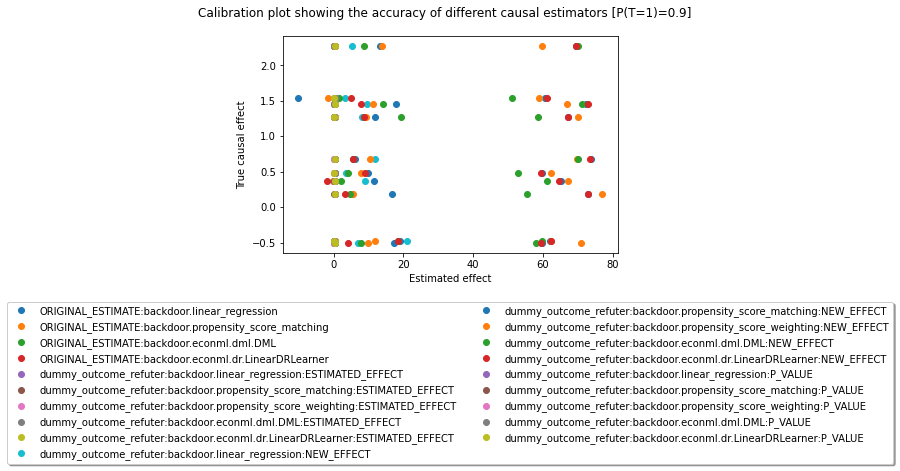

Printing MAE of various estimates: 
ORIGINAL_ESTIMATE:backdoor.propensity_score_matching 65.7694692162915
ORIGINAL_ESTIMATE:backdoor.econml.dr.LinearDRLearner 65.56836800262045
ORIGINAL_ESTIMATE:backdoor.linear_regression 65.51306209336121
ORIGINAL_ESTIMATE:backdoor.econml.dml.DML 60.05246116825989
dummy_outcome_refuter:backdoor.propensity_score_matching:NEW_EFFECT 12.938758300412061
dummy_outcome_refuter:backdoor.econml.dml.DML:NEW_EFFECT 7.9056753419619925
dummy_outcome_refuter:backdoor.propensity_score_weighting:NEW_EFFECT 7.8497026510187755
dummy_outcome_refuter:backdoor.linear_regression:NEW_EFFECT 7.615560283914524
dummy_outcome_refuter:backdoor.econml.dr.LinearDRLearner:NEW_EFFECT 6.165483303948203
dummy_outcome_refuter:backdoor.propensity_score_matching:P_VALUE 0.834777462281575
dummy_outcome_refuter:backdoor.propensity_score_weighting:P_VALUE 0.8107976708723845
dummy_outcome_refuter:backdoor.linear_regression:P_VALUE 0.8070156055790599
dummy_outcome_refuter:backdoor.econml.dr.

In [15]:
##This plot shows the Mean Absolute Error of the Orginal Estimate from the true value and of the New Effect from 
#the expected value for each estimator.
plot_MAEs(res)

### Ranking based on Original Estimate

The Original Estimate is calculated in the presence of the True Value (that is, the ground truth). However in many real life datasets, the ground truth may not be known. Hence, we want the ranking produced by our refutation tests to be in coherence with that obtained from the Original Estimates. According to the Original Estimate values, the ranking of the estimators should be as follows (the method with the least MAE should get the best rank):
1. DMLCateEstimator 
2. Propensity Score Matching 
3. LinearRegression 
4. LinearDRLearner 

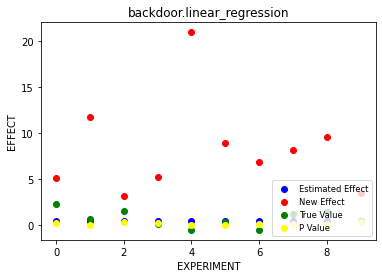

83.42726751886549


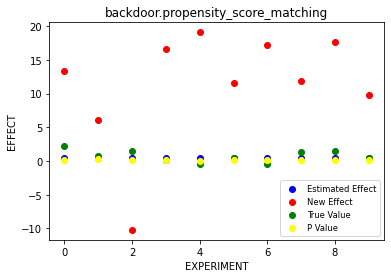

113.11895258637284


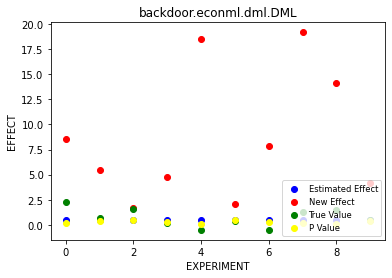

86.32841809934015


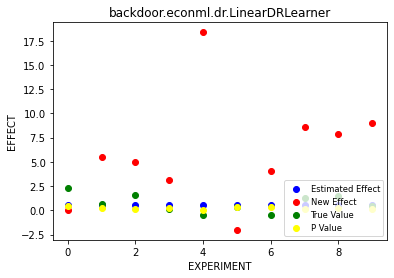

59.641462089752174


<Figure size 432x288 with 0 Axes>

In [16]:
#This plot shows the deviation of the original estimate, the new effect and the estimated effect from the true value
refuter = 'dummy_outcome_refuter'
deviation_list = []
for estimator in estimator_list:
    plot_estimators_and_refuters(refuter, estimator)
    avg_deviation = ((res[refuter+':'+estimator+':NEW_EFFECT']).sum(axis=0))
    print(avg_deviation)
    deviation_list.append(avg_deviation)

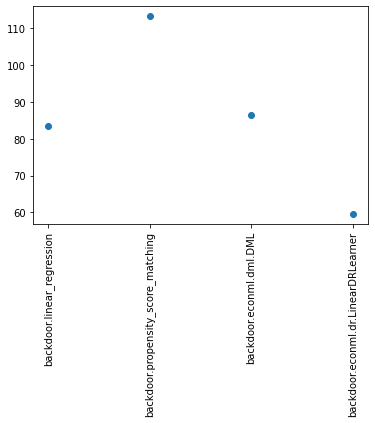

backdoor.linear_regression: 83.42726751886549
backdoor.propensity_score_matching: 113.11895258637284
backdoor.econml.dml.DML: 86.32841809934015
backdoor.econml.dr.LinearDRLearner: 59.641462089752174


In [17]:
plot_deviations(estimator_list, deviation_list)
for i in range(len(estimator_list)):
    print(estimator_list[i] +": "+ str(deviation_list[i]))

In [18]:
{k: v for k, v in sorted(zip(estimator_list, deviation_list), key=lambda item: item[1], reverse = True)}

{'backdoor.propensity_score_matching': 113.11895258637284,
 'backdoor.econml.dml.DML': 86.32841809934015,
 'backdoor.linear_regression': 83.42726751886549,
 'backdoor.econml.dr.LinearDRLearner': 59.641462089752174}

### Ranking based on New Effect (Refutatation results) 

The ranking based on absolute value of deviations is :
1. DML
2. Linear DR Learner 
3. Propensity Score Matching
4. Linear Regression

#### We can see that this ranking produces the same top-ranked estimator as the one based on Original Estimate. Thus ranking based on the unobserved confounding error solves the problem and gives us a close-to-correct ranking amongst methods.